# 可視化・EDA/前処理フロー演習

では、講義を踏まえて実際に可視化・EDAと前処理のフローを体験してみましょう。\
順にやるといういうよりは、実際のデータ分析の流れと同様、可視化・EDAと前処理を行き来しながら手探りでデータ整形を進めます。\
最終的に回帰分析に向けて、時間窓処理をかけた配列を準備したらゴールです。

講義で扱った内容については、***斜字体太字で表示しておきます***。

## ライブラリのimport

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## 準備：演習用データセットの作成 (ここは説明は割愛、とりあえず以下実行しておいてください)

欠損の追加

In [2]:
url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv"
df = pd.read_csv(url, index_col=0, parse_dates=True)
df.head()

HUFL    HULL       MUFL   MULL   LUFL   LULL  \
date                                                                     
2016-07-01 00:00:00  41.130001  12.481  36.535999  9.355  4.424  1.311   
2016-07-01 01:00:00  37.528000  10.136  33.936001  7.532  4.435  1.215   
2016-07-01 02:00:00  37.946999  11.309  35.330002  9.007  2.100  0.000   
2016-07-01 03:00:00  38.952000  11.895  35.543999  9.436  3.380  1.215   
2016-07-01 04:00:00  38.113998  11.476  35.410000  9.623  2.036  0.000   

                            OT  
date                            
2016-07-01 00:00:00  38.661999  
2016-07-01 01:00:00  37.124001  
2016-07-01 02:00:00  36.465000  
2016-07-01 03:00:00  33.608501  
2016-07-01 04:00:00  31.850500

In [3]:
row_num, col_num = df.shape

In [4]:
N = 20  # 最大で欠損させる要素数
np.random.seed(123)  # ランダムシードの固定
missing_value_rows = np.random.randint(
    low=0, high=row_num, size=N
)  # 欠損値の行をサンプリング
missing_value_cols = np.random.randint(
    low=0, high=col_num, size=N
)  # 欠損値の列サンプリング

In [5]:
for i in range(N):
    r, c = missing_value_rows[i], missing_value_cols[i]
    # print([r,c]) # 欠損値の場所
    df.iloc[r, c] = "None"  # 欠損値文字列('None')を代入

In [6]:
missing_value_rows_bool = (
    df["HUFL"] == "None"
)  # HUFLが'None'の行だけTrue,それ以外でFalseのSeries
df[missing_value_rows_bool]

HUFL    HULL       MUFL    MULL   LUFL LULL         OT
date                                                                       
2016-11-16 13:00:00  None  12.398  39.001999  10.079  2.484  0.0  25.356501
2017-03-28 04:00:00  None  14.659  40.744999  12.813    0.0  0.0  22.108999

外れ値の追加

In [7]:
M = 20  # 最大で欠損させる要素数
np.random.seed(111)  # ランダムシードの固定
missing_value_rows = np.random.randint(
    low=0, high=row_num, size=M
)  # 外れ値の行をサンプリング
missing_value_cols = np.random.randint(
    low=0, high=col_num, size=M
)  # 外れ値の列サンプリング
rand_values = np.random.rand(M) * (10**4)  # 外れ値の値をサンプリング

In [8]:
for i in range(M):
    r, c = missing_value_rows[i], missing_value_cols[i]
    # print([r,c]) # 欠損値の場所
    df.iloc[r, c] = rand_values[i]  # 欠損値文字列('None')を代入

作成データの保存

In [9]:
df.to_csv("ETT_disturbed.csv")

## 本番：可視化・EDA/前処理 (わからなくなったらここから実行)

さて、ではこれで欠損値や外れ値を含むデータが得られたテイで分析を進めていきましょう。

### 使用するデータセットの読み込み

今回は[ETTデータセット](https://github.com/zhouhaoyi/ETDataset)を一部改変したデータを使います。ETTデータセットについては詳しくは[ごちきかの解説記事](https://gochikika.ntt.com/Datasets/ett.html)を参照してください。

まずは、データをファイルパスからロードしてきます。

In [10]:
path = "ETT_disturbed.csv"
df = pd.read_csv(path)

先頭の数行を確認してみましょう

In [11]:
df.head()

date                HUFL                HULL  \
0  2016-07-01 00:00:00   41.13000106811523  12.480999946594238   
1  2016-07-01 01:00:00   37.52799987792969   10.13599967956543   
2  2016-07-01 02:00:00  37.946998596191406  11.309000015258787   
3  2016-07-01 03:00:00   38.95199966430664  11.895000457763672   
4  2016-07-01 04:00:00   38.11399841308594   11.47599983215332   

                MUFL               MULL                LUFL  \
0   36.5359992980957  9.354999542236328   4.423999786376953   
1  33.93600082397461  7.532000064849853   4.434999942779541   
2  35.33000183105469  9.006999969482422  2.0999999046325684   
3  35.54399871826172  9.435999870300291   3.380000114440918   
4  35.40999984741211  9.623000144958496  2.0360000133514404   

                 LULL                  OT  
0  1.3109999895095823    38.6619987487793  
1  1.2150000333786009  37.124000549316406  
2                 0.0   36.46500015258789  
3  1.2150000333786009   33.60850143432617  
4                 0.0  31.850500106811523

ここで、`date`がindexとなっていないことに注意が必要です。今indexは今`0,1,2,...`となっています。時系列データをpandasで取り扱う場合、一般に日時をindexに指定しておくと便利です。

また、`date`列の型を確認すると、

In [12]:
df.dtypes["date"]

dtype('O')

In [13]:
print(df["date"].iloc[0])
print(type(df["date"].iloc[0]))

2016-07-01 00:00:00
<class 'str'>


このように`object`となっており、str型を含む列だということがわかります。日時情報なので、datetime型として読み込んでおくと便利です。

では、それを踏まえてindexを変更してみましょう。`read_csv`時に`index_co=0l` (どの列をindexに指定するか)を`0`と指定して、`parse_dates=True` (indexをdatetime型として解釈)としておけば正しく読み込むことができます。

In [14]:
df = pd.read_csv(path, index_col=0, parse_dates=True)

ではindexが設定できたかを確認してみましょう。

In [15]:
df.head()

HUFL                HULL  \
date                                                          
2016-07-01 00:00:00   41.13000106811523  12.480999946594238   
2016-07-01 01:00:00   37.52799987792969   10.13599967956543   
2016-07-01 02:00:00  37.946998596191406  11.309000015258787   
2016-07-01 03:00:00   38.95199966430664  11.895000457763672   
2016-07-01 04:00:00   38.11399841308594   11.47599983215332   

                                  MUFL               MULL                LUFL  \
date                                                                            
2016-07-01 00:00:00   36.5359992980957  9.354999542236328   4.423999786376953   
2016-07-01 01:00:00  33.93600082397461  7.532000064849853   4.434999942779541   
2016-07-01 02:00:00  35.33000183105469  9.006999969482422  2.0999999046325684   
2016-07-01 03:00:00  35.54399871826172  9.435999870300291   3.380000114440918   
2016-07-01 04:00:00  35.40999984741211  9.623000144958496  2.0360000133514404   

                                   LULL                  OT  
date                                                         
2016-07-01 00:00:00  1.3109999895095823    38.6619987487793  
2016-07-01 01:00:00  1.2150000333786009  37.124000549316406  
2016-07-01 02:00:00                 0.0   36.46500015258789  
2016-07-01 03:00:00  1.2150000333786009   33.60850143432617  
2016-07-01 04:00:00                 0.0  31.850500106811523

In [16]:
df.index

DatetimeIndex(['2016-07-01 00:00:00', '2016-07-01 01:00:00',
               '2016-07-01 02:00:00', '2016-07-01 03:00:00',
               '2016-07-01 04:00:00', '2016-07-01 05:00:00',
               '2016-07-01 06:00:00', '2016-07-01 07:00:00',
               '2016-07-01 08:00:00', '2016-07-01 09:00:00',
               ...
               '2018-06-26 10:00:00', '2018-06-26 11:00:00',
               '2018-06-26 12:00:00', '2018-06-26 13:00:00',
               '2018-06-26 14:00:00', '2018-06-26 15:00:00',
               '2018-06-26 16:00:00', '2018-06-26 17:00:00',
               '2018-06-26 18:00:00', '2018-06-26 19:00:00'],
              dtype='datetime64[ns]', name='date', length=17420, freq=None)

### データセットの仕様を確認

レコード数とカラム数を確認します

In [17]:
row_num, col_num = df.shape
print("レコード数:", row_num, ", カラム数:", col_num)

レコード数: 17420 , カラム数: 7


データの型を確認します。

In [18]:
df.dtypes

HUFL    object
HULL    object
MUFL    object
MULL    object
LUFL    object
LULL    object
OT      object
dtype: object

In [19]:
df["HUFL"].iloc[0], type(df["HUFL"].iloc[0])

('41.13000106811523', str)

dtypesがobjectになっています。
どうやらfloat値であって欲しい各カラムの値ですが、str型として解釈されているようです。
floatに変換を試みてみましょう。

In [20]:
try:
    df = df.astype(float)  # エラーが出るコード
except Exception as e:  # エラーの内容を取得
    display(e)  # エラーの内容を表示

ValueError("could not convert string to float: 'None'")

エラーメッセージによると、文字列`'None'`があり、float値に変換できないとの旨が書かれています。
どうやらこのデータは欠損値を`'None'`という文字列で表現しているデータのようです。

このように、欠損値は必ずしも「値なし」で表現されるとは限りません。データの仕様によってはとても大きな値や負の値、ゼロなどで表現されることもあります。

欠損値(`'None'`)の数を数えてみましょう。

In [21]:
missing_location = (
    df == "None"
)  # 値が'None'になっているところだけTrue, それ以外FalseのDataFrame
display(missing_location.sum())  # 値が'None'になっている個数を各カラムごとに表示

HUFL    2
HULL    2
MUFL    5
MULL    3
LUFL    2
LULL    2
OT      4
dtype: int64

では`'None'`を`np.nan` (floatとして扱える欠損値)に置き換えてみましょう。

In [22]:
df = df.mask(df == "None", np.nan)  # 値が'None'になっているところをnp.nanに置換

無事に置き換わっているか、floatへの変換を再度試みて確認しましょう。

In [23]:
df = df.astype(float)

In [24]:
df.dtypes

HUFL    float64
HULL    float64
MUFL    float64
MULL    float64
LUFL    float64
LULL    float64
OT      float64
dtype: object

### ***要約統計量の確認***
(関連する[ごちきか記事](https://gochikika.ntt.com/Visualization_and_EDA/descriptive_statistics.html))

では、講義で紹介した通り`pandas.DataFrame.describe`関数を使って要約統計量を簡易的に表示してみましょう。

まず、インデックス(日時)の仕様を確認します。`datetime_is_numeric=True`とすれば、datetime型を数値のように扱うことができます。

In [25]:
df.index.to_series().describe(datetime_is_numeric=True)

count                  17420
mean     2017-06-28 21:30:00
min      2016-07-01 00:00:00
25%      2016-12-29 10:45:00
50%      2017-06-28 21:30:00
75%      2017-12-27 08:15:00
max      2018-06-26 19:00:00
Name: date, dtype: object

また、他のカラムの要約統計量も確認できます。

In [26]:
df.describe(
    include="all"
)  # include='all' はデータ型によらず全てのカラムを表示することを表す。

HUFL          HULL          MUFL          MULL          LUFL  \
count  17418.000000  17418.000000  17415.000000  17417.000000  17418.000000   
mean      37.880908      9.919433     44.644784      9.971766     -2.555147   
std       68.622709    105.330349     77.951383    106.400922     83.839654   
min        0.000000    -18.680000     11.205000     -6.594000    -14.350000   
25%       30.156000      4.523000     37.394001      5.683000     -9.254000   
50%       37.193001      9.131000     41.388000      9.328000     -3.774000   
75%       44.062000     13.152000     46.078999     11.258000      2.527000   
max     8065.910506   9504.391649   8138.443779   9433.728691   9472.218294   

               LULL            OT  
count  17418.000000  17416.000000  
mean      -1.327906     27.422849  
std       79.667080     77.036356  
min      -31.462000     -2.646500  
25%       -2.505000     16.469500  
50%       -1.226000     26.577000  
75%        0.000000     35.585999  
max     9984.737437   7278.490965

※各統計量の意味
- count: そのカラムの（欠損値を除く）カウント数。
- mean: 標本平均。
- std: 標本標準偏差（ここでは不偏分散の平方根のこと）。
- min: 最小値。
- 25%: 第一四分位点。
- 50%: 中央値。
- 75%: 第三四分位点。
-max: 最大値。



さて、この要約統計量の結果から違和感を見つけて幾つかの前処理を施しましょう。

### ***欠損値処理***
 (関連する[ごちきか記事](https://gochikika.ntt.com/Preprocessing/missing_value.html))

In [27]:
row_num

17420

`row_num`と`count`を比較すると、各カラムがいくつかの欠損値を含むことがわかります。これが実際に欠損値を含む場合の挙動です。

実際にいずれかの値が欠損している列を抜き出してきて確認してみましょう。

In [28]:
missing_value_rows_bool = df.isnull().any(
    axis=1
)  # いずれか(any)がnanの行だけTrue,それ以外でFalseのSeries
df[missing_value_rows_bool]  # いずれかの値が欠損している列を抜き出して表示

HUFL    HULL       MUFL    MULL    LUFL   LULL  \
date                                                                       
2016-07-05 00:00:00  35.518002  10.220  32.300999   8.444   3.209  0.000   
2016-07-05 15:00:00  42.889000  14.157        NaN  11.902   2.943  0.000   
2016-08-09 06:00:00  46.659000  15.916  45.597000     NaN   1.269  0.000   
2016-10-10 04:00:00  37.612000  10.722        NaN   7.586   3.849  1.493   
2016-10-29 14:00:00  42.805000  13.068  40.075001  10.481     NaN  0.000   
2016-11-16 13:00:00        NaN  12.398  39.001999  10.079   2.484  0.000   
2016-11-23 01:00:00  42.470001     NaN  37.448002  10.990   4.648  1.258   
2016-12-22 19:00:00  50.512001  14.157        NaN  10.052   5.352  1.386   
2017-02-22 00:00:00  44.146000  14.241  41.521999  11.875   2.516  0.000   
2017-03-28 04:00:00        NaN  14.659  40.744999  12.813   0.000  0.000   
2017-04-04 00:00:00  42.722000  13.822        NaN  12.197   0.000  0.000   
2017-05-20 11:00:00  30.492001     NaN  88.297997  11.982 -13.050 -2.921   
2017-05-29 17:00:00  32.585999  10.052        NaN  12.197 -11.141 -3.774   
2017-05-31 12:00:00  28.900000   9.131  88.297997  11.768 -10.288 -2.783   
2017-12-13 19:00:00  23.705999   0.000  30.504999   0.000  -7.186    NaN   
2018-01-11 19:00:00  54.868000   6.031  54.952000   3.190   0.000    NaN   
2018-03-15 16:00:00  29.319000   6.785  42.084999     NaN -13.060 -2.655   
2018-04-02 17:00:00  33.340000   7.958  42.192001   8.363  -8.028 -1.525   
2018-04-17 05:00:00  25.716999   7.372  35.839001   8.176     NaN -1.621   
2018-05-16 07:00:00  29.738001   6.701  41.254002     NaN -11.173 -2.484   

                            OT  
date                            
2016-07-05 00:00:00        NaN  
2016-07-05 15:00:00  30.752001  
2016-08-09 06:00:00  39.639000  
2016-10-10 04:00:00  22.938999  
2016-10-29 14:00:00  18.105000  
2016-11-16 13:00:00  25.356501  
2016-11-23 01:00:00   6.240500  
2016-12-22 19:00:00  18.545000  
2017-02-22 00:00:00        NaN  
2017-03-28 04:00:00  22.108999  
2017-04-04 00:00:00  26.943001  
2017-05-20 11:00:00  41.737999  
2017-05-29 17:00:00  45.693001  
2017-05-31 12:00:00        NaN  
2017-12-13 19:00:00  14.052500  
2018-01-11 19:00:00  10.976500  
2018-03-15 16:00:00  35.366001  
2018-04-02 17:00:00        NaN  
2018-04-17 05:00:00  17.763500  
2018-05-16 07:00:00  39.956001

欠損値を埋めずに諸々やるとどうなるか試してみましょう。データフレームをnumpy配列に変換した後、平均を計算してみます。


In [29]:
df.to_numpy().mean(axis=0)

array([nan, nan, nan, nan, nan, nan, nan])

このように欠損値`nan`に何らかの演算を行った結果は全て`nan`になり、計算ができなくなります。

では次は欠損値を直前の値で埋めてみましょう。`pandas.DataFrame.fillna`関数で`method=ffill`を指定することで可能です。

In [31]:
df = df.fillna(method="ffill").astype(
    float
)  # なぜかstr型になってしまうのでastypeでfloatにも変換しておく

先ほど欠損箇所を確認したのと同じ手順で値が埋まったか確認してみましょう！

In [32]:
missing_value_rows_bool = df.isnull().any(
    axis=1
)  # いずれか(any)がnanの行だけTrue,それ以外でFalseのSeries
df[missing_value_rows_bool]  # いずれかの値が欠損している列を抜き出して表示

Empty DataFrame
Columns: [HUFL, HULL, MUFL, MULL, LUFL, LULL, OT]
Index: []

### ***外れ値処理***
(関連する[ごちきか記事](https://gochikika.ntt.com/Preprocessing/outlier.html))

改めて要約統計量を確認します。欠損値が埋まったので`count`が`row_num`と一致します。

In [33]:
df.describe(
    include="all"
)  # include='all' はデータ型によらず全てのカラムを表示することを表す。

HUFL          HULL          MUFL          MULL          LUFL  \
count  17420.000000  17420.000000  17420.000000  17420.000000  17420.000000   
mean      37.881329      9.919612     44.646342      9.971776     -2.555374   
std       68.618782    105.324307     77.940975    106.391765     83.834871   
min        0.000000    -18.680000     11.205000     -6.594000    -14.350000   
25%       30.156000      4.523000     37.394001      5.683000     -9.254000   
50%       37.193001      9.131000     41.388000      9.315000     -3.774000   
75%       44.062000     13.152000     46.078999     11.258000      2.527000   
max     8065.910506   9504.391649   8138.443779   9433.728691   9472.218294   

               LULL            OT  
count  17420.000000  17420.000000  
mean      -1.327928     27.423445  
std       79.662508     77.027695  
min      -31.462000     -2.646500  
25%       -2.505000     16.469500  
50%       -1.226000     26.577000  
75%        0.000000     35.585999  
max     9984.737437   7278.490965

全てのカラムで、平均(`mean`)や分位点(`25%`,`50%`,`75%`)と比べて異様に`max`の値が大きいことがわかります。これは全体的な分布から外れているため、外れ値である可能性が非常に高いです。


`HUFL`を例に可視化で確認してみましょう

<Axes: xlabel='date'>

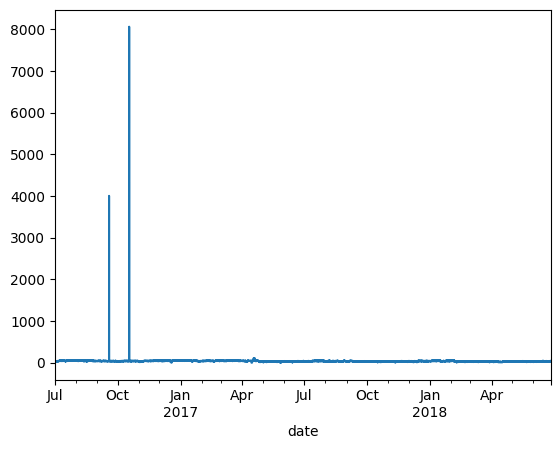

In [34]:
df["HUFL"].plot()

明らかに異常な値が混ざっていますね。

こちらを取り除きます。今回は平均±3σ(標準偏差の3倍)を基準に、それより外側の値を除去します。

除去した後の欠損は、今回は線形補間で埋めてみましょう。

In [35]:
means = df.mean()  # 平均
stds = df.std()  # 標準偏差(standard diviation)
print("means:\n", means)
print("")
print("stds:\n", stds)

means:
 HUFL    37.881329
HULL     9.919612
MUFL    44.646342
MULL     9.971776
LUFL    -2.555374
LULL    -1.327928
OT      27.423445
dtype: float64

stds:
 HUFL     68.618782
HULL    105.324307
MUFL     77.940975
MULL    106.391765
LUFL     83.834871
LULL     79.662508
OT       77.027695
dtype: float64


In [36]:
upper_thresholds = means + 3 * stds  # 上限：平均+3σ(標準偏差の3倍)
lower_thresholds = means - 3 * stds  # 下限:平均-3σ(標準偏差の3倍)
print("upper:\n", upper_thresholds)
print("")
print("lower:\n", lower_thresholds)

upper:
 HUFL    243.737676
HULL    325.892533
MUFL    278.469267
MULL    329.147070
LUFL    248.949240
LULL    237.659598
OT      258.506529
dtype: float64

lower:
 HUFL   -167.975019
HULL   -306.053309
MUFL   -189.176582
MULL   -309.203518
LUFL   -254.059989
LULL   -240.315453
OT     -203.659639
dtype: float64


該当する外れ値の数を確認します。

In [37]:
outliers_bool = (df > upper_thresholds) | (
    df < lower_thresholds
)  # 閾値の外側(=外れ値)だけTrueなdataframe
outliers_bool.sum()

HUFL    2
HULL    4
MUFL    2
MULL    6
LUFL    2
LULL    2
OT      2
dtype: int64

外れ値を除去し、線形補間します。

In [38]:
df = df.mask(outliers_bool, np.nan)  # 外れ値を一旦np.nanに置き換え
df = df.interpolate(method="linear")  # nanを線形補間

<Axes: xlabel='date'>

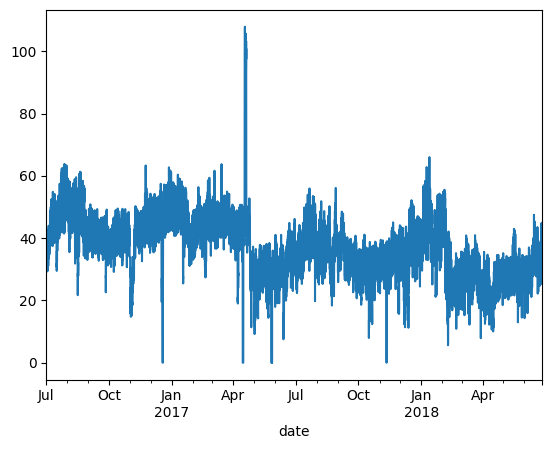

In [39]:
df["HUFL"].plot()

見てみるとある程度外れ値は取り除かれています。

※本来はもう少し厳しい基準を設けて、April右の100を超える値なども除去してもいいかもしれません。実際、先ほど外れ値を取り除いた影響で標準偏差がさらに小さくなっているので、再度同じ操作を繰り返すことでより厳しい閾値の下での外れ値除去もできます。
こういったより高度な方法についてはごちきか本編を参考にしてみて下さい。

### ***可視化***
(関連する[ごちきか記事](https://gochikika.ntt.com/Visualization_and_EDA/time_series_plot.html))

ではいくつか代表的な可視化を行ってみましょう。

まず、ごちきかのコードを参照に、系列を縦に並べたプロットをしてみましょう。

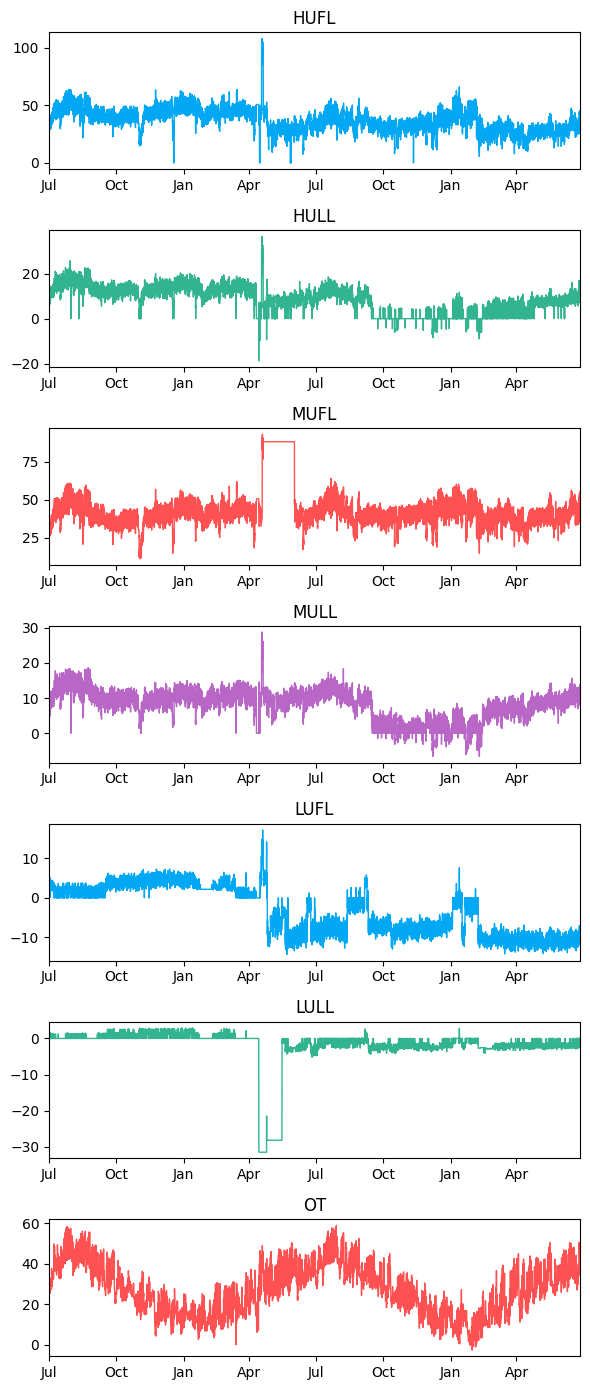

In [40]:
import itertools
from matplotlib.dates import DateFormatter


def plot_figs(df):
    """
    うけとったデータをすべてプロットする関数
    :param df: plotしたいpandas.Dataframe
    :return:
    """
    color_iter = itertools.cycle(["#02A8F3", "#33B490", "#FF5151", "#B967C7"])
    n_figs = df.columns.size
    fig = plt.figure(figsize=(6, 2.0 * n_figs), dpi=100)
    x = df.index
    for i in range(n_figs):
        y = df.iloc[:, i]
        title = df.columns[i]
        ax = fig.add_subplot(n_figs, 1, i + 1)
        ax.plot(x, y, color=next(color_iter), linewidth=1.0)
        ax.xaxis.set_major_formatter(DateFormatter("%b"))
        ax.set_xlim(x[0], x[-1])
        ax.set_title(title, fontsize=12)
    fig.tight_layout()
    plt.show()
    plt.close()


plot_figs(df)

ここで、今回のデータではOil Temperature(=OT)が目的変数として想定されています。

高い相関をいくつか目視で見出すことができます。

※また、なんとなく除いた方が良さそうな異常期間(Aprilの右あたり)が見えてきますが、今回は先ほど実施した最低限の外れ値除去だけ実施して無視します。(予測精度が出ない時などに除去してみるのはありだと思います。)

### ***自己相関関数と相互相関関数***
（関連する[ごちきか記事](https://gochikika.ntt.com/Visualization_and_EDA/auto_cross_corr.html)）


目的変数である`OT`を例に自己相関関数をプロットします。`statsmodels`モジュールの`statsmodels.api.tsa.stattools.acf`関数で自己相関を計算することができます。

計算式：
$$r_{xx}(k)=
\begin{equation}
\frac{E[(x(t)-\mu)(x(t-k)-\mu)]}{\sigma^2}
\end{equation}
$$

In [41]:
import statsmodels.api as sm

acf = sm.tsa.stattools.acf(df["OT"])  # 自己相関関数(auto correlation function)
print(acf)

[1.         0.99395938 0.97986844 0.95976889 0.93603227 0.91101609
 0.88683185 0.86515464 0.84707906 0.83289817 0.82253856 0.81571797
 0.81208589 0.8114535  0.81387    0.81949944 0.82857836 0.84112577
 0.85674032 0.87428797 0.89242942 0.90919095 0.92261362 0.9309378
 0.93273208 0.92722861 0.91532664 0.89837448 0.8783094  0.85715654
 0.83661294 0.81819236 0.80282513 0.79083886 0.78212287 0.77637663
 0.7732936  0.77279225 0.77494256 0.77993275 0.78800517 0.79923127
 0.81324193]


プロットは以下のコードでできます。

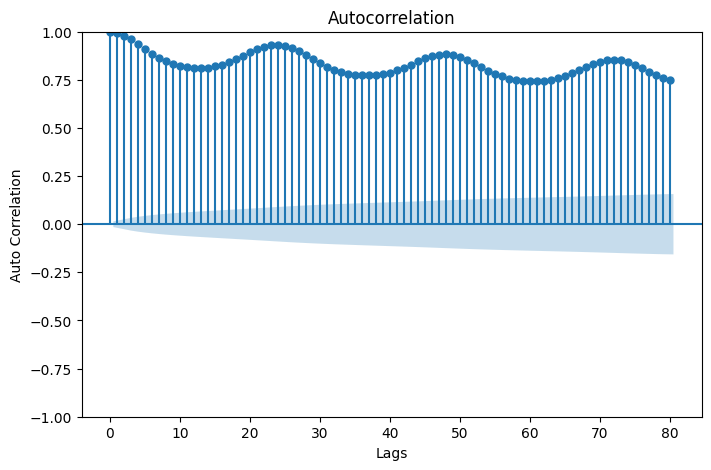

In [42]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(df["OT"], lags=80, ax=ax1)  # グラフを自動作成 #最大ラグ80
ax1.set_xlabel("Lags")
ax1.set_ylabel("Auto Correlation")
plt.show()
plt.close("all")

水色の網掛けは95%信頼区間で、目安としてこれより外側の相関は統計的に有意(≒偶然ではなく意味がある)とみなせます。

まず、ラグ数をみると24ラグごとに高い相関を持つ周期性を確認できます。これはデータが1時間刻みであることを考慮すると、24時間=1日の周期性に対応しており非常に自然な結果です。

また、単純にラグが大きくなると次第に相関が減少(≒過去の影響が薄まっていく)ことが確認できて、これも自然な結果です。

相関の絶対的な大きさを見ると、時間と共に減少するものの最大の1.0に近い大きな値を取り続けていることから、過去の自身の値に大きく依存していることがわかります。

最大ラグ数を増やしてより大きいスケールで見てみましょう、

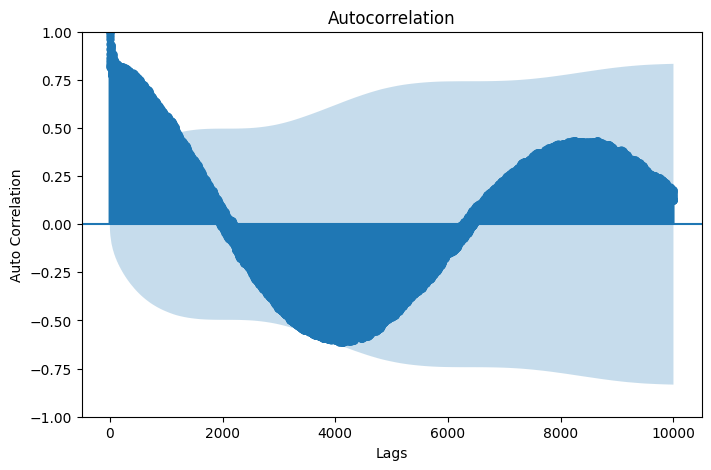

In [43]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(
    df["OT"], lags=10000, ax=ax1
)  # グラフを自動作成 #最大ラグ10000
ax1.set_xlabel("Lags")
ax1.set_ylabel("Auto Correlation")
plt.show()
plt.close("all")

1万時間の長さにしてみました。24時間×365日=8760時間より、1年周期のピークをラグが8760のあたりに見出すことができます。また全体的な相関も時間と共に減少していることがわかります。このように自己相関で周期性や過去に対する依存性を確認することができます。

※網掛けの範囲が大きくなっているのは、2年分しかないデータに対して1年という大きなラグをとっているので、計算に用いることのできるデータ数が最大ラグ80時間の時の結果と比して少なくなっている影響です。

では先のプロットで説明変数`HUFL`と`HULL`は高い相関を持つように見えたので、これらに対して相互相関関数をプロットしてみましょう。

計算式：
$$r_{xy}(k)=
\frac{E\left[\left(x(t)-\mu_x\right)\left(y(t-k)-\mu_y\right)\right]}
{\sqrt{\sigma_x^2} \sqrt{\sigma_y^2}}$$

In [44]:
# xとyの相互相関関数を表示する関数
def calc_ccf(x, y, lags):
    ccf_xy = sm.tsa.ccf(x, y)[1 : lags + 1]
    ccf_yx = sm.tsa.ccf(y, x)[
        :lags
    ]  # (x, y)を基準にしているので、(y, x)はマイナスのラグ
    ccf_both_side = np.concatenate((ccf_yx[::-1], ccf_xy))
    return ccf_both_side


plot_size = 100
ccf = calc_ccf(
    df["HUFL"], df["HULL"], lags=plot_size
)  # 相互相関関数(cross correlation function)

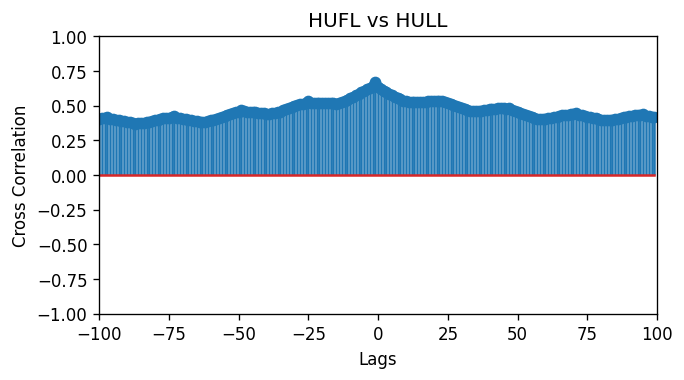

In [45]:
x_axis = np.arange(-plot_size, plot_size)
fig = plt.figure(figsize=(6, 3), dpi=120)
ax = fig.add_subplot(111)
ax.stem(x_axis, ccf)
ax.set_xlim([-plot_size, plot_size])
ax.set_ylim([-1, 1])
ax.set_title("{} vs {}".format("HUFL", "HULL"))
ax.set_xlabel("Lags")
ax.set_ylabel("Cross Correlation")
plt.show()

ほぼ同時刻に高い相関を持つことがわかります。相互相関関数の計算式を考慮すると、ラグがプラスの側の相関が高ければyがxに対して時間的に先行しており、ラグがマイナスの側の相関が高ければxがyに対して時間的に先行していると解釈できます。

どっちが先行していいるのかはっきりさせるため、拡大してみましょう。最大値を赤くプロットします。

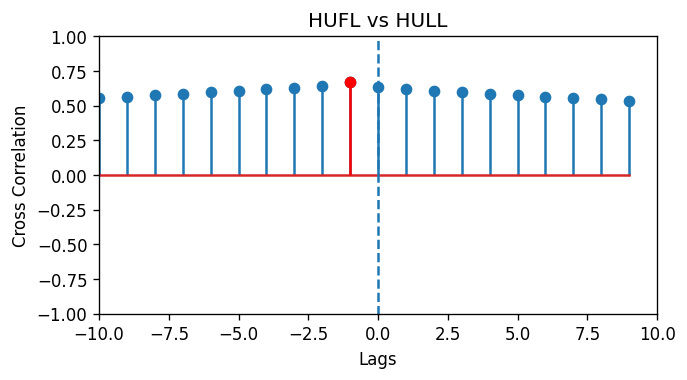

In [46]:
plot_size = 10
ccf = calc_ccf(
    df["HUFL"], df["HULL"], lags=plot_size
)  # 相互相関関数(cross correlation function)

x_axis = np.arange(-plot_size, plot_size)
fig = plt.figure(figsize=(6, 3), dpi=120)
ax = fig.add_subplot(111)
ax.stem(x_axis, ccf)
ax.stem(x_axis[np.argmax(ccf)], np.max(ccf), "r")
ax.axvline(x=0, ymin=-1, ymax=1, linestyle="--")
ax.set_xlim([-plot_size, plot_size])
ax.set_ylim([-1, 1])
ax.set_title("{} vs {}".format("HUFL", "HULL"))
ax.set_xlabel("Lags")
ax.set_ylabel("Cross Correlation")
plt.show()

この結果から、`HUFL`の方が`HULL`に対して時間的に先行している、原因側の変数である可能性が高くなりました。(しかしそのラグはわずか1時間程度でほぼ同時的ではあります。)

また、やはり相関の絶対的な大きさ自体も0.5付近とそこそこ大きいことがわかります。

講義でも少し触れましたが、相関の高すぎる複数の変数を説明変数として用いると、多重共線性という現象が起こり回帰の性能が下がってしまうので、こういった変数ペアには注意が必要です。(直感的には、ほぼ同じ説明要素が二つあった時、どちらからの寄与か判断できないので不安定になる)

　次に、それぞれの説明変数と目的変数の間の相互相関をチェックしてみましょう。

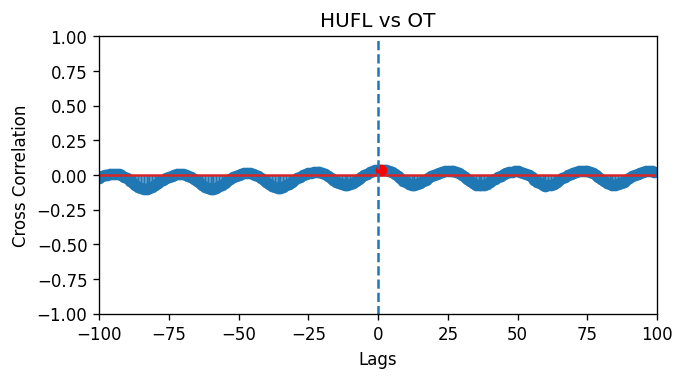

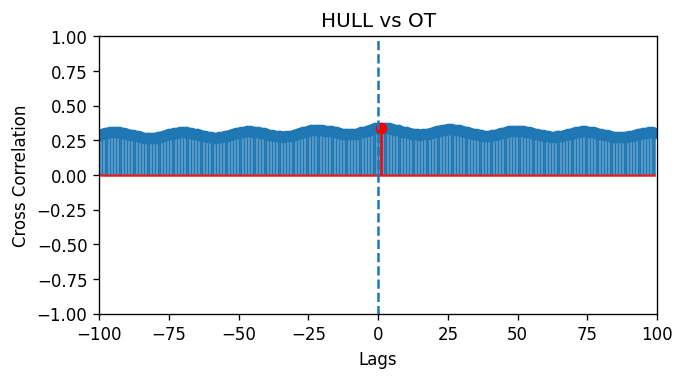

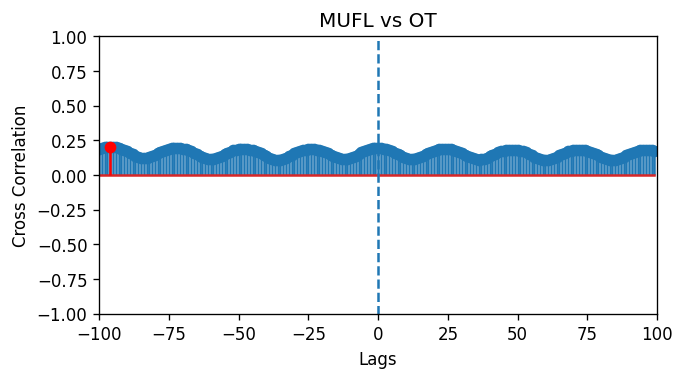

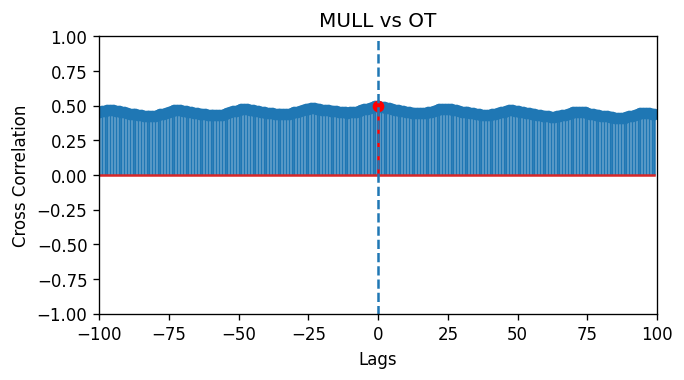

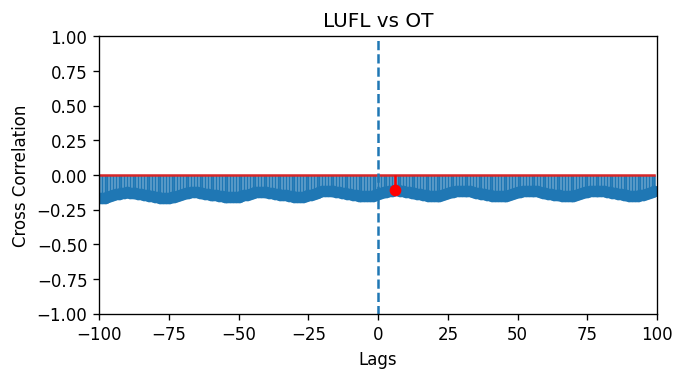

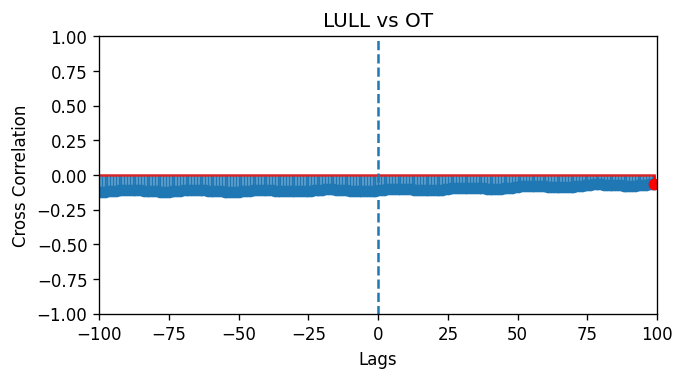

In [47]:
plot_size = 100

for col in df.columns[:-1]:
    ccf = calc_ccf(
        df[col], df["OT"], lags=plot_size
    )  # 相互相関関数(cross correlation function)

    x_axis = np.arange(-plot_size, plot_size)
    fig = plt.figure(figsize=(6, 3), dpi=120)
    ax = fig.add_subplot(111)
    ax.stem(x_axis, ccf)
    ax.stem(x_axis[np.argmax(ccf)], np.max(ccf), "r")
    ax.axvline(x=0, ymin=-1, ymax=1, linestyle="--")
    ax.set_xlim([-plot_size, plot_size])
    ax.set_ylim([-1, 1])
    ax.set_title("{} vs {}".format(col, "OT"))
    ax.set_xlabel("Lags")
    ax.set_ylabel("Cross Correlation")
    plt.show()

基本的には、目的変数と相関の高い変数を説明変数として入れるべきです。今回のように7変数程度しか説明変数候補がない時には大きな効果はありませんが、時には数千変数から有用な変数を選択する必要があり、そういった場合に相互相関の確認は有用です。

相互相関の強さを一目で確認する方法として、ヒートマップもあります。今回はラグを0に固定した相互相関をヒートマップとしてプロットしてみましょう。`pandas.DataFrame.corr`関数で容易に計算可能です。

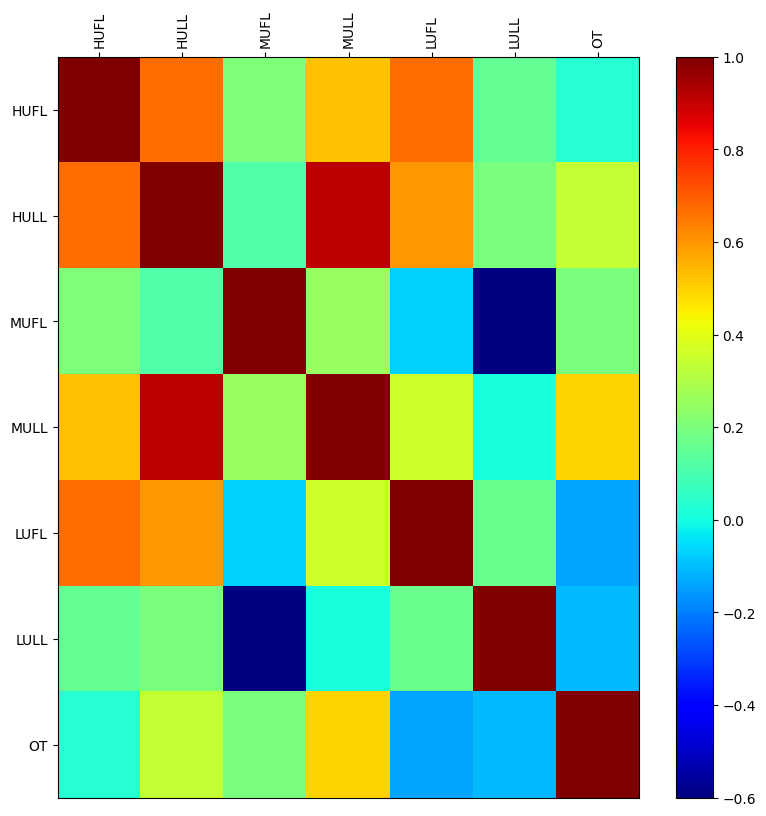

In [ ]:
# ヒートマップで表してみる。
# ここではラグなし（k=0）の時をしめす
def plot_corr_heatmap(df, figsize=(8, 8)):
    """
    相互相関のヒートマップをプロット
    Parameters
    ----------
    df: pandas Dataframe
    figsize: int
        figure size
    Returns
    -------

    """

    df_corr = df.corr()  # 相互相関を計算
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout()
    heatmap = ax.pcolor(df_corr, cmap=plt.cm.jet)

    ax.set_xticks(np.arange(df_corr.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(df_corr.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(df_corr.columns.values, minor=False, rotation=90)
    ax.set_yticklabels(df_corr.index.values, minor=False)
    pp = fig.colorbar(heatmap, aspect=20)
    plt.show()


plot_corr_heatmap(df)

### ***窓枠処理***
(関連する[ごちきか記事](https://gochikika.ntt.com/Preprocessing/time-window.html))

窓枠処理の具体的な実装については、次の線形モデリングの章の演習にて解説するので、割愛します。
講義では入力データは多変量の場合3次元配列になると説明しましたが、演習ではプログラム上扱いやすいように2次元配列に潰した(flattenした)ものが使用されています。